# Studies with EFT nanoGEN samples

We will use two flavors of samples:
- SMEFTatNLO with SM settings: `TTWJetsToLNuEWK_5f_NLO`
- SMEFTatNLO with NP settings: `TTWJetsToLNuEWK_5f_EFT_myNLO`
    - cpt = 1, cpQ3 = 1, cpQM = 1, ctZ = 1, ctW = 1.
    However, there is some funny MG behaviour, so we can't be certain that these settings have actually worked.
    The reported x-sec by MG is `8.987e-02 +- 8.6e-05 pb`


In [1]:
import uproot4
import numpy as np
from uproot_methods import TLorentzVectorArray

from coffea.processor import LazyDataFrame
from coffea.analysis_objects import JaggedCandidateArray

import glob

In [2]:
# example for nanoGEN
f=uproot4.open('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANOGEN_v1/output_10.root')
# standard nanoAOD
#f=uproot.open('/hadoop/cms/store/user/dspitzba/nanoAOD/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8__RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20_ext1-v1/1A0B18ED-E6A3-F04F-B634-E990954C06AB.root')
tree = f['Events']
df = LazyDataFrame(tree, flatten=True)

## check the content
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | uint32_t                 | AsDtype('>u4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
nGenJetAK8           | uint32_t                 | AsDtype('>u4')
GenJetAK8_eta        | float[]                  | AsJagged(AsDtype('>f4'))
GenJetAK8_mass       | float[]                  | AsJagged(AsDtype('>f4'))
GenJetAK8_phi        | float[]                  | AsJagged(AsDtype('>f4'))
GenJetAK8_pt         | float[]                  | AsJagged(AsDtype('>f4'))
nGenJet              | uint32_t                 | AsDtype('>u4')
GenJet_eta           | float[]                  | AsJagged(AsDtype('>f4'))
GenJet_mass          | float[]                  | AsJagged(AsDtype('>f4'))
GenJet_phi           | float[]                  | AsJagged(AsDt

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import mplhep
plt.style.use(mplhep.style.CMS)

In [4]:
GenPart = JaggedCandidateArray.candidatesfromcounts(
    df['nGenPart'],
    pt=df['GenPart_pt'],
    eta=df['GenPart_eta'],
    phi=df['GenPart_phi'],
    mass=df['GenPart_mass'],
    pdgId=df['GenPart_pdgId'],
    status=df['GenPart_status'],
    genPartIdxMother=df['GenPart_genPartIdxMother'],
    statusFlags=df['GenPart_statusFlags']
)

GenJet = JaggedCandidateArray.candidatesfromcounts(
    df['nGenJet'],
    pt=df['GenJet_pt'],
    eta=df['GenJet_eta'],
    phi=df['GenJet_phi'],
    mass=df['GenJet_mass'],
    hadronFlavour=df['GenJet_hadronFlavour'],
    partonFlavour=df['GenJet_partonFlavour'],
)

# some special GenJets
spec_jet = GenJet[(abs(GenJet.eta)>1.7) & (abs(GenJet.eta)<4.7) & (GenJet.pt>25)]
spec_jet_loose = GenJet[(abs(GenJet.eta)>1.2) & (abs(GenJet.eta)<4.7) & (GenJet.pt>25)]
high_p_spec   = spec_jet[spec_jet.p4.p.argmax()]
high_pt_spec  = spec_jet[spec_jet.pt.argmax()]
high_eta_spec = spec_jet[abs(spec_jet.eta).argmax()]

# we always have three generated Ws with statusFlag 13
W = GenPart[((abs(GenPart.pdgId)==24) & ((GenPart.statusFlags & (1 << 13)) > 0))]
# the incoming W bosons either from top or q/g
incomingW = GenPart[((abs(GenPart.pdgId)==24) & (GenPart.status==22))]
# last copy of the tops
top = GenPart[((abs(GenPart.pdgId)==6) & ((GenPart.statusFlags & (1 << 13)) > 0))]
# give the spectators a shot. this is how I've previously done that
hardScatter = GenPart[((GenPart.genPartIdxMother==0) | (GenPart.genPartIdxMother==1))]
spectator = GenPart[(((GenPart.genPartIdxMother==0) | (GenPart.genPartIdxMother==1)) & (abs(GenPart.pdgId)<6))]

# all Ws
allW = GenPart[(abs(GenPart.pdgId)==24)]

## Jets
centralLight = GenJet[((GenJet.pt>30) & (abs(GenJet.eta)<2.4) & (GenJet.hadronFlavour<5))]
forward = GenJet[((GenJet.pt>25) & (abs(GenJet.eta)>2.0) & (abs(GenJet.eta)<4.7))]
bjet = GenJet[((GenJet.pt>30) & (abs(GenJet.eta)<2.4) & (GenJet.hadronFlavour==5))]

## leptons. use prompt (0) and last copy (13) status flags
muon = GenPart[((abs(GenPart.pdgId)==13) & ((GenPart.statusFlags & (1 << 0)) > 0) & ((GenPart.statusFlags & (1 << 13)) > 0) )]
electron = GenPart[((abs(GenPart.pdgId)==11) & ((GenPart.statusFlags & (1 << 0)) > 0) & ((GenPart.statusFlags & (1 << 13)) > 0) )]

In [5]:
# status bit fromHardProcess=8, isHardProcess=7
GenPart[((GenPart.statusFlags & (1 << 7)) > 0) & ((GenPart.statusFlags & (1 << 13)) > 0)].genPartIdxMother

<JaggedArray [[-1 -1] [-1 -1] [-1 -1 20 20] ... [-1 -1 22 22] [-1 -1 11 16 16] [-1 -1 10 10]] at 0x7eff376c6d90>

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


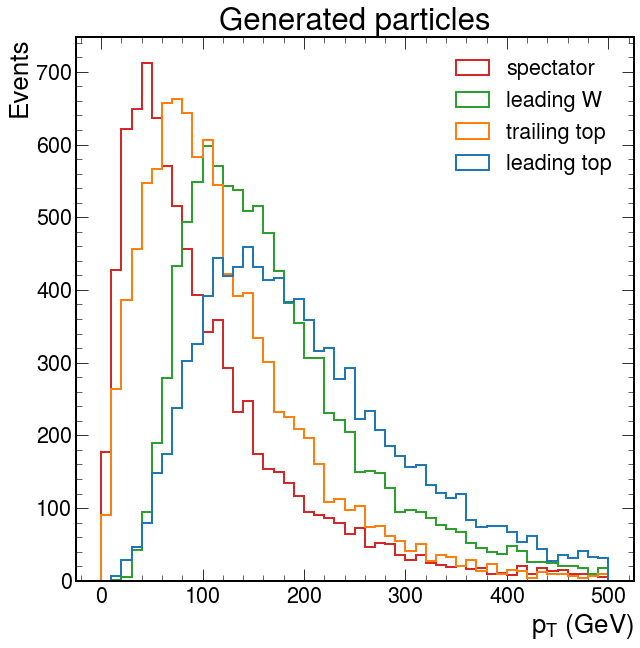

In [6]:
figure=plt.figure(1)
plt.hist([top.pt.max(), top.pt.min(), W.pt.max(), spectator.pt.flatten()], label=['leading top', 'trailing top', 'leading W', 'spectator'], bins=50, range=[0, 500], histtype='step', linewidth=2)
plt.xlabel(r'$p_T$ (GeV)')
plt.ylabel('Events')
plt.title('Generated particles')
plt.legend()
plt.show()

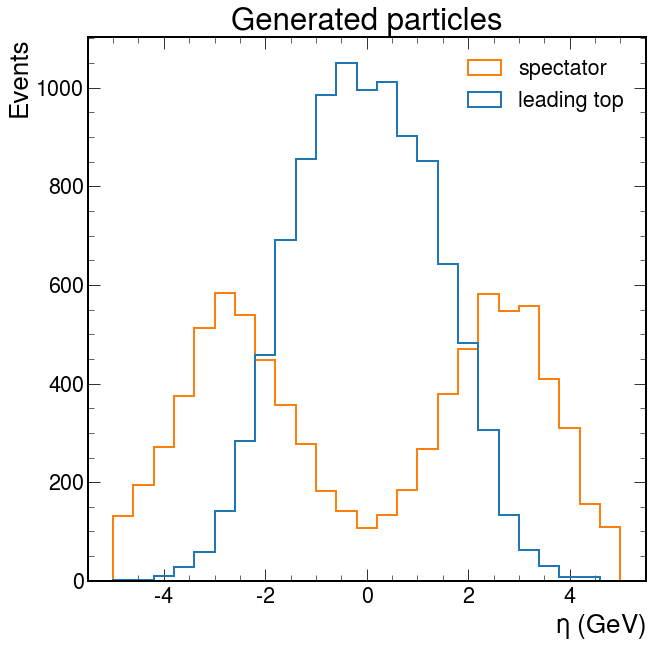

In [7]:
figure=plt.figure(1)
plt.hist([top[top.pt.argmax()].eta.flatten(), spectator.eta.flatten()], label=['leading top', 'spectator'], bins=25, range=[-5, 5], histtype='step', linewidth=2)
plt.xlabel(r'$\eta$ (GeV)')
plt.ylabel('Events')
plt.title('Generated particles')
plt.legend()
plt.show()

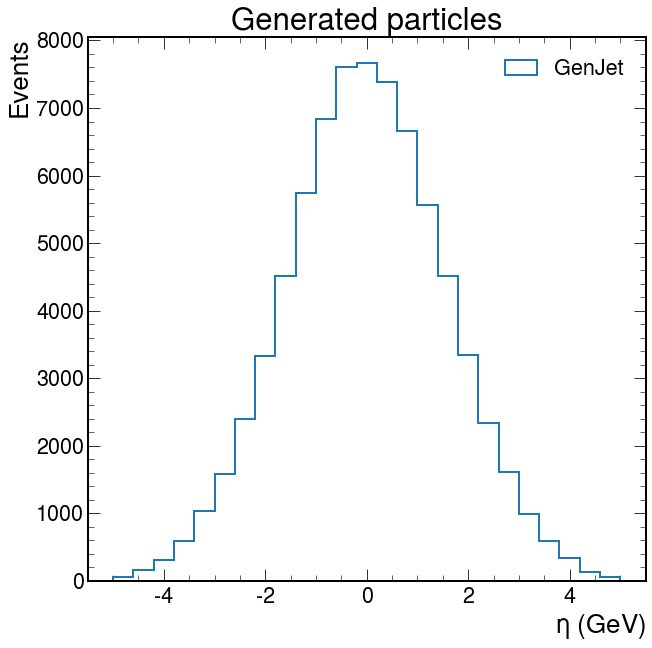

In [8]:
figure=plt.figure(1)
plt.hist([GenJet[GenJet.pt>25].eta.flatten()], label=['GenJet'], bins=25, range=[-5, 5], histtype='step', linewidth=2)
plt.xlabel(r'$\eta$ (GeV)')
plt.ylabel('Events')
plt.title('Generated particles')
plt.legend()
plt.show()

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


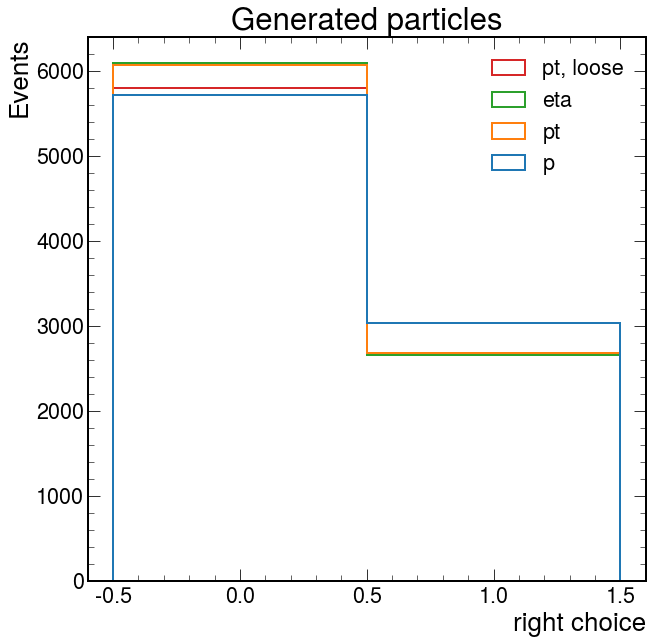

In [9]:
spec_jet_loose = GenJet[(abs(GenJet.eta)>1.8) & (abs(GenJet.eta)<4.7) & (GenJet.pt>25)]

figure=plt.figure(1)
plt.hist([\
          high_p_spec.match(spectator, deltaRCut=0.4).flatten(),
          high_pt_spec.match(spectator, deltaRCut=0.4).flatten(),
          high_eta_spec.match(spectator, deltaRCut=0.4).flatten(),
          spec_jet_loose[spec_jet_loose.pt.argmax()].match(spectator, deltaRCut=0.4).flatten()
         ], label=['p', 'pt', 'eta', 'pt, loose'], bins=2, range=[-0.5, 1.5], histtype='step', linewidth=2)
plt.xlabel('right choice')
plt.ylabel('Events')
plt.title('Generated particles')
plt.legend()
plt.show()

# The problem is that what we have as "spectator" here is not the showered particle,
# and therefore might not be in close proximity to a GenJet

#high_p_spec.match(spectator, deltaRCut=0.4)

In [10]:
high_p_spec.match(spectator, deltaRCut=0.4).flatten().sum()/(high_p_spec.counts.sum())

0.3464044815365268

In [11]:
# Find out in how many cases the spectator is actually found in a GenJet
GenJet.match(spectator, deltaRCut=0.4).any().sum()/spectator.counts.sum()

0.6869131106620706

The problem seems to be that sometimes there's a shower attached to the spectator, but not always. Need to find a way to get the final product of the spectator

In [12]:
GenPart[GenPart[GenPart[GenPart.genPartIdxMother].genPartIdxMother].genPartIdxMother]

<JaggedCandidateArray [[<Row 53> <Row 53> <Row 64> ... <Row 45> <Row 44> <Row 44>] [<Row 124> <Row 124> <Row 132> ... <Row 68> <Row 88> <Row 106>] [<Row 179> <Row 179> <Row 183> ... <Row 164> <Row 162> <Row 175>] ... [<Row 672160> <Row 672160> <Row 672168> ... <Row 672158> <Row 672158> <Row 672151>] [<Row 672222> <Row 672222> <Row 672235> ... <Row 672235> <Row 672187> <Row 672209>] [<Row 672286> <Row 672286> <Row 672291> ... <Row 672256> <Row 672271> <Row 672271>]] at 0x7eff35c79d00>

In [13]:
GenPart.genPartIdxMother

<JaggedArray [[-1 -1 0 ... 62 64 64] [-1 -1 0 ... 52 56 64] [-1 -1 0 ... 43 45 49] ... [-1 -1 0 ... 45 46 48] [-1 -1 0 ... 46 50 63] [-1 -1 0 ... 49 52 54]] at 0x7eff36738fd0>

In [14]:
mother = GenPart[GenPart.genPartIdxMother]
mother[(((mother.genPartIdxMother==0) | (mother.genPartIdxMother==1)) & (abs(mother.pdgId)<6))].pt

<JaggedArray [[54.0 54.0] [14.46875 14.46875] [47.5 47.5] ... [141.0 141.0 141.0] [] [61.75]] at 0x7eff35c52340>

In [160]:
def find_first_parent(in_mother, in_pdg, maxgen=10):
    """Finds the first parent with a PDG ID different from the daughter
    :param in_mother: Index of the mother particle for each gen. particle
    :type in_mother: JaggedArray
    :param pdg: PDG ID for each gen. particle
    :type pdg: JaggedArray
    :param maxgen: Number of maximal generations to go back, defaults to 10
    :type maxgen: int, optional
    :return: Index and PDG id of first parent with diff. PDG ID
    :rtype: tuple of JaggedArrays
    """
    out_mother = (in_mother>=0) * in_mother # Index of parent, output
    tmp_mother = out_mother # Index of parent, working copy
    found = np.zeros(in_pdg.size) # Mask

    # Loop over generations
    # If mother particle ID is same as daughter particle ID, do nothing
    # Otherwise, update parent_id, but only once!
    for i in range(maxgen):
        # Make sure we dont go negative
        tmp_mother = (tmp_mother>=0) * tmp_mother
        update = (in_pdg[tmp_mother]!=in_pdg) * (found==0)
        out_mother = update*tmp_mother + (~update) * out_mother
        found=found+update
        tmp_mother = in_mother[tmp_mother]

    return out_mother

def find_hardscatter_parent(in_mother, in_pdg, maxgen=10):
    """Finds the hard scatter parent (particle with parent index 0 or 1)
    :param in_mother: Index of the mother particle for each gen. particle
    :type in_mother: JaggedArray
    :param pdg: PDG ID for each gen. particle
    :type pdg: JaggedArray
    :param maxgen: Number of maximal generations to go back, defaults to 10
    :type maxgen: int, optional
    :return: Index and PDG id of first parent with diff. PDG ID
    :rtype: tuple of JaggedArrays
    """
    out_mother = (in_mother>=0) * in_mother # Index of parent, output
    tmp_mother = out_mother # Index of parent, working copy
    tmp_mother2 = out_mother # Index of parent, working copy
    found = np.zeros(in_pdg.size) # Mask
    
    # Loop over generations
    # If mother particle ID is same as daughter particle ID, do nothing
    # Otherwise, update parent_id, but only once!
    for i in range(maxgen):
        # Make sure we dont go negative
        tmp_mother = (tmp_mother>=0) * tmp_mother
        tmp_mother2 = (tmp_mother2>=0) * tmp_mother2 # this should be one iteration behind
        
        update = ((tmp_mother==0) | (tmp_mother==1)) * (found==0) # is true if mother is 0 or 1 and not yet found
        out_mother = update*tmp_mother2 + (~update) * out_mother # takes the true parts of tmp_mother, and the old stuff
        found=found+update # # updates found
        tmp_mother2 = tmp_mother
        tmp_mother = in_mother[tmp_mother] # take the new mothers

    return out_mother


In [156]:
# find the remnants of spectators
hardscatter_parent = find_hardscatter_parent(GenPart.genPartIdxMother, GenPart.pdgId, maxgen=10)
spectator_remnants = GenPart[(((GenPart[hardscatter_parent].genPartIdxMother==0) | (GenPart[hardscatter_parent].genPartIdxMother==1)) & (abs(GenPart[hardscatter_parent].pdgId)<6))]
# Find out in how many cases the spectator is actually found in a GenJet
GenJet.match(spectator_remnants, deltaRCut=0.4).any().sum()/(spectator_remnants.counts>0).sum()
# this does not (yet?) include the hard scatter GenPart

0.9714727207892547

In [164]:
find_first_parent(GenPart.genPartIdxMother, GenPart.pdgId)[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       14, 14, 15, 15, 15, 16, 16, 16, 16, 24, 21, 21, 25, 25, 14, 18,  0,
       25, 30,  0,  0, 25, 29, 17, 14, 15, 16, 20, 20, 21, 28, 21, 28,  0,
        5, 36, 44, 45, 49, 52, 52, 53, 53, 54, 54, 54, 58, 53, 62, 64, 64],
      dtype=int32)

In [162]:
GenPart[find_first_parent(GenPart.genPartIdxMother, GenPart.pdgId)].pdgId[0]

array([  21,   21,   21,   21,   21,   21,   21,   21,   21,   21,   21,
         21,   21,   21,   21,   21,   21,   24,   24,    6,    6,    6,
         -6,   -6,   -6,   -6,  -24,   24,   24,  -24,  -24,   24,    2,
         21,  -24,   -4,   21,   21,  -24,    3,   -1,   24,    6,   -6,
          5,    5,   24,    2,   24,    2,   21,    1,   21, 5222,  523,
        111,  111,  111, 5122, 5122,  521,  521,  521, -413, 5122, -423,
        111,  111], dtype=int32)

In [66]:
GenPart.localindex

<JaggedArray [[0 1 2 ... 65 66 67] [0 1 2 ... 63 64 65] [0 1 2 ... 48 49 50] ... [0 1 2 ... 49 50 51] [0 1 2 ... 62 63 64] [0 1 2 ... 54 55 56]] at 0x7eff35cefd30>

In [108]:
W = GenPart[((abs(GenPart.pdgId)==24) & ((GenPart.statusFlags & (1 << 13)) > 0))]

In [109]:
W

<JaggedCandidateArray [[<Row 14> <Row 21> <Row 25>] [<Row 79> <Row 89> <Row 93>] [<Row 144> <Row 154> <Row 159>] ... [<Row 672129> <Row 672139> <Row 672142>] [<Row 672181> <Row 672188> <Row 672189>] [<Row 672247> <Row 672254> <Row 672257>]] at 0x7eff36393d30>

In [188]:
W_index = GenPart.localindex[((abs(GenPart.pdgId)==24) & ((GenPart.statusFlags & (1 << 13)) > 0))]

In [189]:
W_index

<JaggedArray [[14 21 25] [11 21 25] [10 20 25] ... [9 19 22] [9 16 17] [10 17 20]] at 0x7eff36458be0>

In [121]:
GenPart.offsets

array([     0,     68,    134, ..., 672172, 672237, 672294])

In [196]:
(W_index+GenPart.offsets[:-1]).flatten()

array([    14,     21,     25, ..., 672247, 672254, 672257])

In [197]:
GenPart[GenPart[((GenPart.pdgId<6) & (GenPart.pdgId>0) & (abs(GenPart[GenPart.genPartIdxMother].pdgId)==24))].genPartIdxMother]

<JaggedCandidateArray [[<Row 14> <Row 21> <Row 25>] [<Row 89> <Row 93>] [<Row 159>] ... [<Row 672139>] [<Row 672181> <Row 672189>] [<Row 672254>]] at 0x7eff364586a0>

In [198]:
Gen_W_had = GenPart[GenPart[((GenPart.pdgId<6) & (GenPart.pdgId>0) & (abs(GenPart[GenPart.genPartIdxMother].pdgId)==24))].genPartIdxMother]

In [200]:
Gen_W_had.counts

array([3, 2, 1, ..., 1, 2, 1])

In [17]:
GenJet_spectator_matched = GenJet[GenJet.match(spectator_remnants, deltaRCut=0.4)]

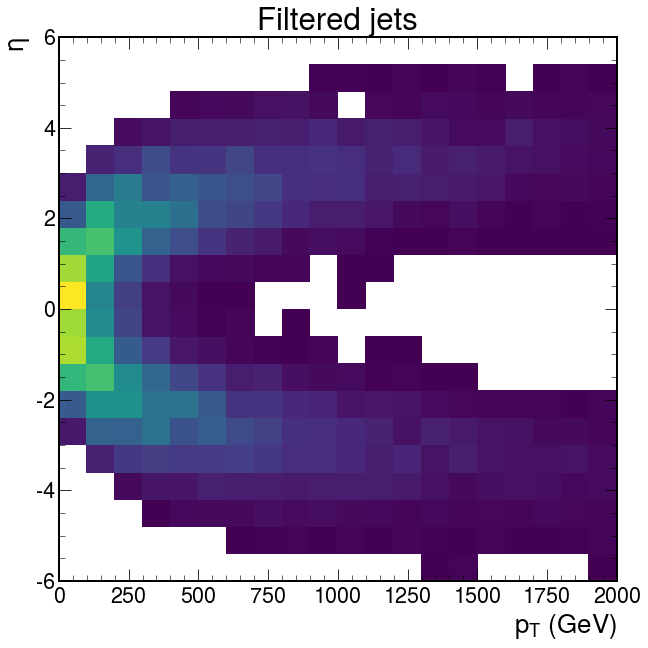

In [18]:
figure=plt.figure(1)
plt.hist2d(GenJet_spectator_matched.p4.p.flatten(), GenJet_spectator_matched.eta.flatten(), bins=20, range=[[0, 2000], [-6,6]], cmin = 1)
plt.xlabel(r'$p_{T}$ (GeV)')
plt.ylabel(r'$\eta$')
plt.title('Filtered jets')

plt.show()

What other handles do I have for finding the spectator?
- highest pt
- highest eta
- highest momentum
- jet that forms the highest m(jj)

In [33]:
spec_jet = GenJet[(abs(GenJet.eta)>1.7) & (abs(GenJet.eta)<4.7) & (GenJet.pt>25) & (GenJet.hadronFlavour!=5)]
high_p_spec   = spec_jet[spec_jet.p4.p.argmax()]
high_pt_spec   = spec_jet[spec_jet.pt.argmax()]
high_eta_spec   = spec_jet[abs(spec_jet.eta).argmax()]

jj = spec_jet.cross(GenJet[((GenJet.pt>30) & (abs(GenJet.eta)<2.4))])
high_mjj_spec = jj[jj.mass.argmax()].i0

print ("Total number of jets:", GenJet.counts.sum())
print ("Total number of jets (pt>25):", GenJet[GenJet.pt>25].counts.sum())

print ("Total number of matched jets:", GenJet_spectator_matched.counts.sum())
print ("Total number of matched jets (pt>25):", GenJet_spectator_matched[GenJet_spectator_matched.pt>25].counts.sum())

print ("Total number of forward jets:", spec_jet.counts.sum())
print ("Total number of matched forward jets:", spec_jet.match(GenJet_spectator_matched, deltaRCut=0.4).any().sum())
print ("Total number of selected forward jets:", high_p_spec.counts.sum())
print ("Total number of selected (p>200) forward jets:", high_p_spec[high_p_spec.p4.p>200].counts.sum())
print ("Total number of selected (p) and matched forward jets:", high_p_spec.match(GenJet_spectator_matched, deltaRCut=0.4).any().sum())
print ("Total number of selected (pt) and matched forward jets:", high_pt_spec.match(GenJet_spectator_matched, deltaRCut=0.4).any().sum())
print ("Total number of selected (eta) and matched forward jets:", high_eta_spec.match(GenJet_spectator_matched, deltaRCut=0.4).any().sum())
eff_p = high_p_spec.match(GenJet_spectator_matched, deltaRCut=0.4).flatten().sum()/(high_p_spec.counts.sum())

print ("Efficiency for highest p jet:", eff_p)
eff_pt = high_pt_spec.match(GenJet_spectator_matched, deltaRCut=0.4).flatten().sum()/(high_pt_spec.counts.sum())
print ("Efficiency for highest pt jet:", eff_pt)
eff_eta = high_eta_spec.match(GenJet_spectator_matched, deltaRCut=0.4).flatten().sum()/(high_eta_spec.counts.sum())
print ("Efficiency for highest eta jet:", eff_eta)
eff_mjj = high_mjj_spec.match(GenJet_spectator_matched, deltaRCut=0.4).flatten().sum()/(high_mjj_spec.counts.sum())
print ("Efficiency for highest mjj jet:", eff_mjj)

Total number of jets: 107980
Total number of jets (pt>25): 75366
Total number of matched jets: 11338
Total number of matched jets (pt>25): 9827
Total number of forward jets: 17824
Total number of matched forward jets: 5482
Total number of selected forward jets: 8446
Total number of selected (p>200) forward jets: 7659
Total number of selected (p) and matched forward jets: 4455
Total number of selected (pt) and matched forward jets: 4068
Total number of selected (eta) and matched forward jets: 4027
Efficiency for highest p jet: 0.5274686242008051
Efficiency for highest pt jet: 0.48164811745204833
Efficiency for highest eta jet: 0.4767937485200095
Efficiency for highest mjj jet: 0.5194220748460445


In [34]:
GenJet_spectator_matched.p4.p

<JaggedArray [[261.92514] [108.45102] [285.61404] ... [2563.1462] [] [165.74307]] at 0x7fb1fc65fe80>

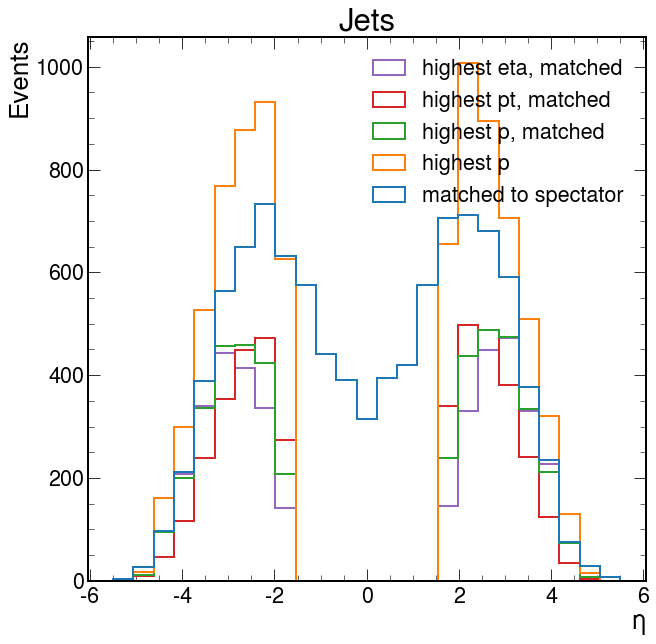

In [35]:
figure=plt.figure(1)
plt.hist([\
          GenJet_spectator_matched[(GenJet_spectator_matched.pt>25)].eta.flatten(),
          high_p_spec.eta.flatten(),
          high_p_spec[high_p_spec.match(GenJet_spectator_matched, deltaRCut=0.4)].eta.flatten(),
          high_pt_spec[high_pt_spec.match(GenJet_spectator_matched, deltaRCut=0.4)].eta.flatten(),
          high_eta_spec[high_eta_spec.match(GenJet_spectator_matched, deltaRCut=0.4)].eta.flatten(),
         ], label=['matched to spectator', 'highest p', 'highest p, matched', 'highest pt, matched', 'highest eta, matched'], bins=25, range=[-5.5, 5.5], histtype='step', linewidth=2)
plt.xlabel(r'$\eta$')
plt.ylabel('Events')
plt.title('Jets')
plt.legend()
plt.show()

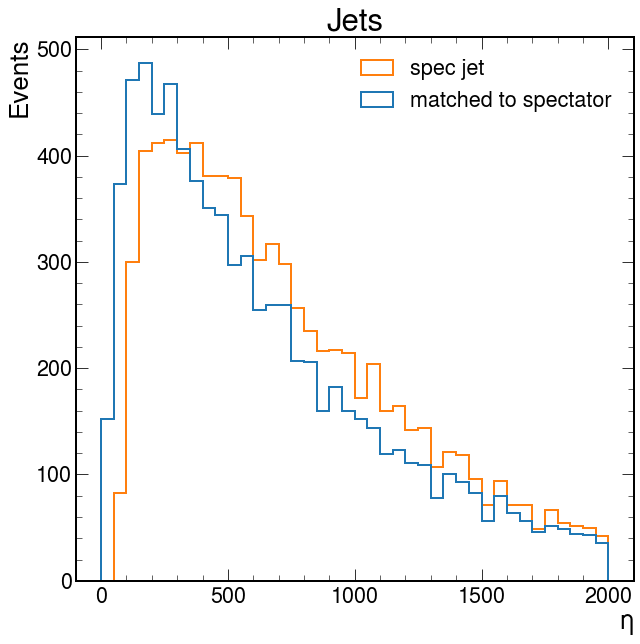

In [39]:
figure=plt.figure(1)
plt.hist([\
          GenJet_spectator_matched[GenJet_spectator_matched.p4.p.argmax()].p4.p.flatten(),
          spec_jet[spec_jet.p4.p.argmax()].p4.p.flatten()
         ], label=['matched to spectator', 'spec jet'], bins=40, range=[0, 2000], histtype='step', linewidth=2)
plt.xlabel(r'$\eta$')
plt.ylabel('Events')
plt.title('Jets')
plt.legend()
plt.show()

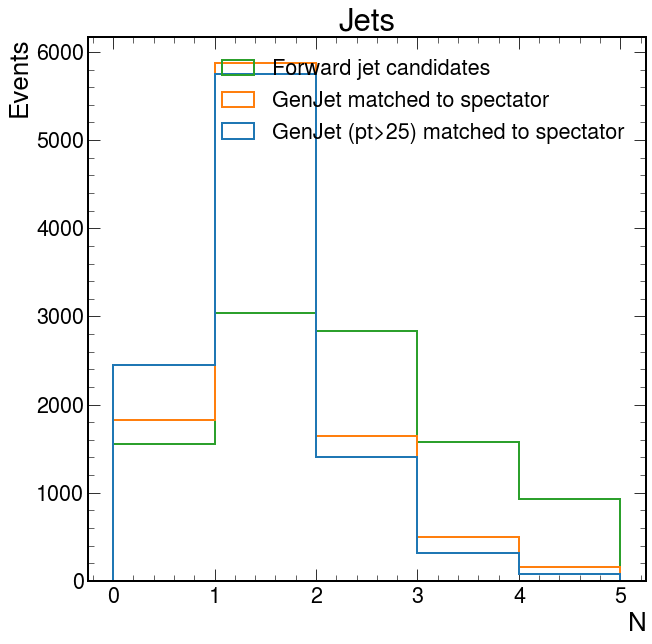

In [29]:
figure=plt.figure(1)
plt.hist([\
          GenJet_spectator_matched[(GenJet_spectator_matched.pt>25)].counts,
          GenJet_spectator_matched.counts,
          spec_jet.counts,
         ], label=['GenJet (pt>25) matched to spectator', 'GenJet matched to spectator', 'Forward jet candidates'], bins=5, range=[0, 5], histtype='step', linewidth=2)
plt.xlabel(r'$N$')
plt.ylabel('Events')
plt.title('Jets')
plt.legend()
plt.show()

In [30]:
spec_jet.match(GenJet_spectator_matched[(GenJet_spectator_matched.pt>25)], deltaRCut=0.4).any().sum()

5482

In [31]:
spec_jet.counts.sum()

17824

In [32]:
high_p_spec.match(GenJet_spectator_matched[(GenJet_spectator_matched.pt>25)], deltaRCut=0.4).any().sum()

4455

In [34]:
spec_jet.counts.sum()

17824

In [35]:
high_eta_spec.match(GenJet_spectator_matched, deltaRCut=0.4).flatten().sum()/(high_eta_spec.counts.sum())

0.4767937485200095

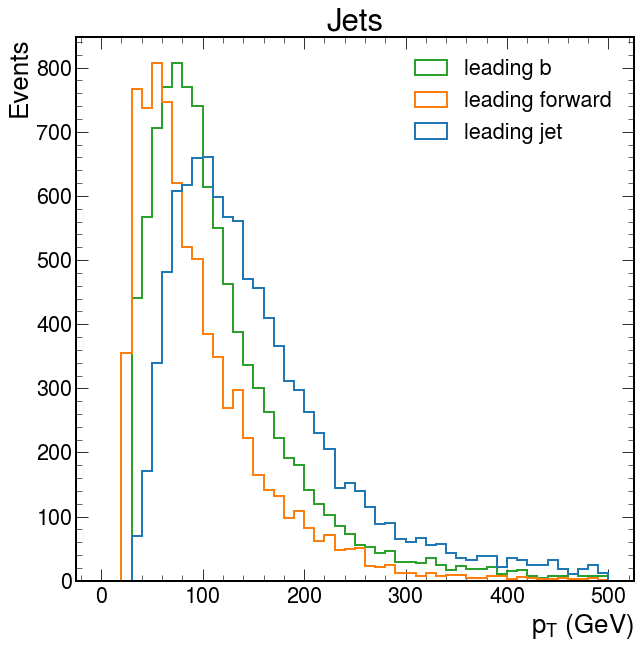

In [12]:
figure=plt.figure(1)
plt.hist([centralLight.pt.max(), forward.pt.max(), bjet.pt.max()], label=['leading jet', 'leading forward', 'leading b'], bins=50, range=[0, 500], histtype='step', linewidth=2)
plt.xlabel(r'$p_T$ (GeV)')
plt.ylabel('Events')
plt.title('Jets')
plt.legend()
plt.show()

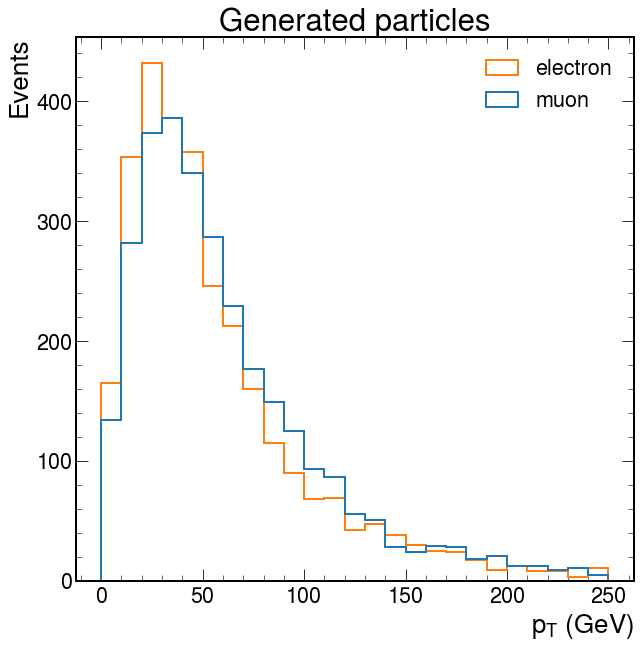

In [23]:
figure=plt.figure(1)
plt.hist([muon.pt.max(), electron.pt.min()], label=['muon', 'electron'], bins=25, range=[0, 250], histtype='step', linewidth=2)
plt.xlabel(r'$p_T$ (GeV)')
plt.ylabel('Events')
plt.title('Generated particles')
plt.legend()
plt.show()

In [13]:
GenJet.p4.p

<JaggedArray [[140.9065 196.40662 243.46269 ... 25.954258 16.966099 25.491096] [473.9648 157.6422 227.15935 ... 108.45102 156.12288 11.203249] [143.7617 87.47755 60.377552 ... 90.949295 907.4374 232.94833] ... [2563.1462 277.37732 119.23776 ... 27.755789 26.66788 20.075773] [437.618 316.0933 546.36884 ... 55.265743 33.919662 75.87001] [259.90637 349.47858 378.4739 ... 12.488545 33.46456 15.670584]] at 0x7f9ff1e83ac8>

In [9]:
import os
import time
import glob
import re
import pandas as pd
from functools import reduce
#from klepto.archives import dir_archive

from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist
import pandas as pd
import uproot_methods
import awkward

#from memory_profiler import profile

from Tools.helpers import loadConfig, getCutFlowTable, mergeArray

from Tools.objects import Collections
from Tools.cutflow import Cutflow

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')


In [10]:
class exampleProcessor(processor.ProcessorABC):
    """Dummy processor used to demonstrate the processor principle"""
    def __init__(self):

        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 5000)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        deltaEta_axis            = hist.Bin("deltaEta",       r"$\eta$", 100, 0, 10)
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis            = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            "leading_top_pt" :   hist.Hist("Counts", dataset_axis, pt_axis),
            "trailing_top_pt" :  hist.Hist("Counts", dataset_axis, pt_axis),
            "leading_lep_pt" :   hist.Hist("Counts", dataset_axis, pt_axis),
            "trailing_lep_pt" :  hist.Hist("Counts", dataset_axis, pt_axis),
            "leading_bjet_pt" :   hist.Hist("Counts", dataset_axis, pt_axis),
            "trailing_bjet_pt" :  hist.Hist("Counts", dataset_axis, pt_axis),
            "leading_W_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),
            "trailing_W_pt" :    hist.Hist("Counts", dataset_axis, pt_axis),
            "spectator_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),
            "fw_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            "leadingForward_p" : hist.Hist("Counts", dataset_axis, p_axis),
            "m_jj" :             hist.Hist("Counts", dataset_axis, mass_axis),
            "m_js" :             hist.Hist("Counts", dataset_axis, mass_axis),
            "deltaEta_jj" :             hist.Hist("Counts", dataset_axis, deltaEta_axis),
            "deltaEta_js" :             hist.Hist("Counts", dataset_axis, deltaEta_axis),
            "deltaEta_any_js" :             hist.Hist("Counts", dataset_axis, deltaEta_axis),
            "deltaEta_bs" :             hist.Hist("Counts", dataset_axis, deltaEta_axis),
            'ht':                hist.Hist("Counts", dataset_axis, ht_axis),
            'ht_central':        hist.Hist("Counts", dataset_axis, ht_axis),
            'N_spec_jet':        hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'totalEvents':      processor.defaultdict_accumulator(int),

        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        # GenPart
        GenPart = JaggedCandidateArray.candidatesfromcounts(
            df['nGenPart'],
            pt=df['GenPart_pt'].content,
            eta=df['GenPart_eta'].content,
            phi=df['GenPart_phi'].content,
            mass=df['GenPart_mass'].content,
            pdgId=df['GenPart_pdgId'].content,
            status=df['GenPart_status'].content,
            genPartIdxMother=df['GenPart_genPartIdxMother'].content,
            statusFlags=df['GenPart_statusFlags'].content
        )
        
        # we always have three generated Ws with statusFlag 13
        W = GenPart[((abs(GenPart.pdgId)==24) & ((GenPart.statusFlags & (1 << 13)) > 0))]
        # the incoming W bosons either from top or q/g
        incomingW = GenPart[((abs(GenPart.pdgId)==24) & (GenPart.status==22))]
        # last copy of the tops
        top = GenPart[((abs(GenPart.pdgId)==6) & ((GenPart.statusFlags & (1 << 13)) > 0))]
        # give the spectators a shot. this is how I've previously done that
        hardScatter = GenPart[((GenPart.genPartIdxMother==0) | (GenPart.genPartIdxMother==1))]
        spectator = GenPart[(((GenPart.genPartIdxMother==0) | (GenPart.genPartIdxMother==1)) & (abs(GenPart.pdgId)<6))]
        
        ## leptons. use prompt (0) and last copy (13) status flags
        muon = GenPart[((abs(GenPart.pdgId)==13) & ((GenPart.statusFlags & (1 << 0)) > 0) & ((GenPart.statusFlags & (1 << 13)) > 0) )]
        electron = GenPart[((abs(GenPart.pdgId)==11) & ((GenPart.statusFlags & (1 << 0)) > 0) & ((GenPart.statusFlags & (1 << 13)) > 0) )]

        muon = muon[abs(muon.eta)<2.4]
        electron = electron[abs(electron.eta)<2.5]
        
        lepton = mergeArray(electron, muon)
        '''
        ok so this is getting **really** awkward (pun slightly intended). because the mergeArray function builds a JaggedArray that has a UnionArry as .content, which in turn
        does not work with .argmax(), we need to build a jagged array just holding the pts
        '''
        lepton_pt = awkward.concatenate([electron.pt, muon.pt], axis=1)
        # getting the index of the leading lepton
        leading_lep_index = lepton_pt.argmax()
        # index of the trailing lepton -> !! if there's only one lepton, it will be the same as the leading one !!
        trailing_lep_index = lepton_pt.argmin()

        leading_lep_pt = lepton[leading_lep_index].p4.fPt.max() # taking the max here has no impact, but otherwise code fails
        leading_lep_eta = lepton[leading_lep_index].p4.fEta.max() # taking the max here has no impact, but otherwise code fails

        trailing_lep_pt = lepton[trailing_lep_index].p4.fPt.max() # taking the max here has no impact, but otherwise code fails
        trailing_lep_eta = lepton[trailing_lep_index].p4.fEta.max() # taking the max here has no impact, but otherwise code fails


        
        ## Jets
        GenJet = JaggedCandidateArray.candidatesfromcounts(
            df['nGenJet'],
            pt = df['GenJet_pt'].content,
            eta = df['GenJet_eta'].content,
            phi = df['GenJet_phi'].content,
            mass = df['GenJet_mass'].content,
            hadronFlavour = df['GenJet_hadronFlavour'].content,
            partonFlavour = df['GenJet_partonFlavour'].content,
        )
        ## Jets
        jet          = GenJet[((GenJet.pt>25) & (abs(GenJet.eta)<4.7)) ]
        light        = GenJet[((GenJet.pt>25) & (abs(GenJet.eta)<4.7) & (GenJet.hadronFlavour<5))]
        centralLight = GenJet[((GenJet.pt>30) & (abs(GenJet.eta)<2.4) & (GenJet.hadronFlavour<5))]
        central      = GenJet[((GenJet.pt>25) & (abs(GenJet.eta)<2.4))]
        forward      = GenJet[((GenJet.pt>25) & (abs(GenJet.eta)>2.0) & (abs(GenJet.eta)<4.7))]
        bjet         = GenJet[((GenJet.pt>30) & (abs(GenJet.eta)<2.4) & (GenJet.hadronFlavour==5))]
        
        fw           = light[abs(light.eta).argmax()] # the most forward light jet
        fw_p         = light[light.p4.p.argmax()] # the highest p
        leadingForward = forward[forward.p4.p.argmax()] # forward jet with highest momentum

        # now implement the best selection we found
        spec_jet = light[(abs(light.eta)>1.7) & (light.p4.p>200)]
        high_p_spec_jet = spec_jet[spec_jet.p4.p.argmax()]
        
        ## other variables
        ht = jet.pt.sum()
        ht_central = central.pt.sum()
        
        selection = ((electron.counts + muon.counts)==2 )
        
        ## Event classifieres
        # We want to get the deltaEta between the most forward jet fw and the jet giving the largest invariant mass with fw, fw2
        jj = fw.cross(light)
        deltaEta_jj = abs(fw.eta - jj[jj.mass.argmax()].i1.eta)
        deltaR = abs(fw.eta - jj[jj.mass.argmax()].i1.eta)
        deltaEtaJJMin = ((deltaEta_jj>2).any())
        
        ## another delta Eta
        
        js = high_p_spec_jet.cross(light)
        deltaEta_js = abs(high_p_spec_jet.eta - js[js.mass.argmax()].i1.eta)
        
        any_js = spec_jet.cross(light)
        deltaEta_any_js = abs(any_js[any_js.mass.argmax()].i0.eta - any_js[any_js.mass.argmax()].i1.eta)
        
        ## another delta Eta
        #bs = high_p_spec_jet.cross(bjet)
        #deltaEta_bs = abs(high_p_spec_jet.eta - bs[bs.mass.argmax()].i1.eta)
        
        something = (GenJet[:,:2].pt>30).any()
        #output['totalEvents']['all'] += len(df['genWeight'])
        
        ### And fill the histograms
        # just the number of electrons and muons
        output['leading_top_pt'].fill(dataset=dataset, pt=top.pt.max().flatten(), weight=df['genWeight'][top.counts>0])
        output['trailing_top_pt'].fill(dataset=dataset, pt=top.pt.min().flatten(), weight=df['genWeight'][top.counts>0])
        output['leading_bjet_pt'].fill(dataset=dataset, pt=bjet[bjet.pt.argmax()].pt.flatten(), weight=df['genWeight'][bjet.counts>0])
        output['trailing_bjet_pt'].fill(dataset=dataset, pt=bjet[bjet.pt.argmin()].pt.flatten(), weight=df['genWeight'][bjet.counts>0])
        output['leading_W_pt'].fill(dataset=dataset, pt=W.pt.max().flatten(), weight=df['genWeight'][W.counts>0])
        output['trailing_W_pt'].fill(dataset=dataset, pt=W.pt.min().flatten(), weight=df['genWeight'][W.counts>0])
        output['spectator_pt'].fill(dataset=dataset, pt=spectator[spectator.pt.argmax()].pt.flatten(), weight=df['genWeight'][spectator.counts>0])
        output['fw_pt'].fill(dataset=dataset, pt=fw.pt.flatten(), weight=df['genWeight'][fw.counts>0])
        output['leadingForward_p'].fill(dataset=dataset, p=leadingForward.p4.p.flatten(), weight=df['genWeight'][leadingForward.counts>0])
        output['m_jj'].fill(dataset=dataset, mass=jj[jj.mass.argmax()].mass.flatten(), weight=df['genWeight'][jj.counts>0])
        output['m_js'].fill(dataset=dataset, mass=js[js.mass.argmax()].mass.flatten(), weight=df['genWeight'][js.counts>0])
        
        output['deltaEta_jj'].fill(dataset=dataset, deltaEta=deltaEta_jj.flatten(), weight=df['genWeight'][jj.counts>0])
        output['deltaEta_js'].fill(dataset=dataset, deltaEta=deltaEta_js.flatten(), weight=df['genWeight'][js.counts>0])
        output['deltaEta_any_js'].fill(dataset=dataset, deltaEta=deltaEta_any_js.flatten(), weight=df['genWeight'][any_js.counts>0])
        #output['deltaEta_bs'].fill(dataset=dataset, deltaEta=deltaEta_bs.flatten(), weight=df['genWeight'][bs.counts>0])
        
        output['leading_lep_pt'].fill(dataset=dataset, pt=leading_lep_pt[selection].flatten(), weight=df['genWeight'][selection])
        output['trailing_lep_pt'].fill(dataset=dataset, pt=trailing_lep_pt[selection].flatten(), weight=df['genWeight'][selection])
        
        output['ht'].fill(dataset=dataset, ht=ht[selection].flatten(), weight=df['genWeight'][selection])
        output['ht_central'].fill(dataset=dataset, ht=ht_central[selection].flatten(), weight=df['genWeight'][selection])
        
        output['N_spec_jet'].fill(dataset=dataset, multiplicity=spec_jet[selection].counts, weight=df['genWeight'][selection])
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [11]:
fileset = {'SM' : glob.glob('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANOGEN_v1/*.root'),
           'EFT': glob.glob('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_EFT_myNLO_RunIIAutumn18_NANOGEN_v1/*.root'),
           'cp8': glob.glob('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_EFT_myNLO_cpt8_RunIIAutumn18_NANOGEN_v1/*.root'),
           'QCD': ['/hadoop/cms/store/user/dspitzba/nanoAOD/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8__RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20_ext1-v1/1A0B18ED-E6A3-F04F-B634-E990954C06AB.root']}

In [12]:
# Get the scheduler from the dask_cluster notebook
from dask.distributed import Client, progress

c = Client(os.environ["DASKSCHEDULER"])

c

KeyError: 'DASKSCHEDULER'

In [48]:
runLocal = False


if not runLocal:
    ## for dask
    exe_args = {
        'client': c,
        #'savemetrics': True,
    }
    exe = processor.dask_executor

else:
    ## for local
    exe_args = {
        'workers': 4,
        'function_args': {'flatten': False}
    }
    exe = processor.futures_executor


In [49]:
output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=exampleProcessor(),
                                      executor=exe,
                                      executor_args=exe_args,
                                      chunksize=250000,
                                     )

In [50]:
bins = {\
        'leading_W_pt':         {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T$ (leading W) (GeV)', 25, 0, 1000)},
        'trailing_W_pt':         {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T$ (trailing W) (GeV)', 25, 0, 250)},
        'leading_lep_pt':         {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T$ (leading lepton) (GeV)', 25, 0, 250)},
        'trailing_lep_pt':         {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T$ (trailing lepton) (GeV)', 25, 0, 250)},
        'leading_top_pt':       {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T$ (leading top) (GeV)', 25, 0, 1000)},
        'trailing_top_pt':       {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T$ (trailing top) (GeV)', 25, 0, 500)},
        'leading_bjet_pt':       {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T$ (leading b-jet) (GeV)', 25, 0, 500)},
        'trailing_bjet_pt':       {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T$ (trailing b-jet) (GeV)', 25, 0, 250)},
        'spectator_pt': {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T$ (spectator) (GeV)', 25, 0, 500)},
        'fw_pt':        {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T$ (most forward jet) (GeV)', 25, 0, 250)},
        'leadingForward_p': {'axis': 'p',        'overflow':'over',  'bins': hist.Bin('p', r'$p$ (hardest forward jet) (GeV)', 25, 0, 5000)},
        'm_jj': {'axis': 'mass',        'overflow':'over',  'bins': hist.Bin('mass', r'$m (jj) max \ (GeV)$', 25, 0, 2000)},
        'm_js': {'axis': 'mass',        'overflow':'over',  'bins': hist.Bin('mass', r'$m (jj) max \ (GeV)$', 25, 0, 2000)},
        'deltaEta_jj': {'axis': 'deltaEta',        'overflow':'over',  'bins': hist.Bin('deltaEta', r'$\Delta\eta (jj) $', 25, 0, 10)},
        'deltaEta_js': {'axis': 'deltaEta',        'overflow':'over',  'bins': hist.Bin('deltaEta', r'$\Delta\eta (jj) $', 25, 0, 10)},
        'deltaEta_any_js': {'axis': 'deltaEta',        'overflow':'over',  'bins': hist.Bin('deltaEta', r'$\Delta\eta (jj) $', 25, 0, 10)},
        'deltaEta_bs': {'axis': 'deltaEta',        'overflow':'over',  'bins': hist.Bin('deltaEta', r'$\Delta\eta (jj) $', 25, 0, 10)},
        'ht': {'axis': 'ht',        'overflow':'over',  'bins': hist.Bin('deltaEta', r'$ H_T $ (GeV)', 20, 0, 2000)},
        'ht_central': {'axis': 'ht',        'overflow':'over',  'bins': hist.Bin('deltaEta', r'$ H_T $ (GeV)', 20, 0, 2000)},
        'N_spec_jet': {'axis': 'multiplicity',        'overflow':'over',  'bins': hist.Bin('multiplicity', r'$ N_{fwd} $', 5, -0.5, 4.5)},
       }

my_labels = {
    'SM': r'$(t\bar{t}Wj)_{EW}$ (SM)',
    'QCD': r'$(t\bar{t}Wj)_{QCD}$ (SM)',
    'EFT': r'$(t\bar{t}Wj)_{EW}$ (EFT mix)',
    'cp8': r'$(t\bar{t}Wj)_{EW}$ $(c_{\varphi t}=8)$',
}

def makePlot(name, processes=['QCD','SM','EFT','cp8']):
    histogram = output[name]
    histogram = histogram.rebin(bins[name]['axis'], bins[name]['bins'])
    
    ax = hist.plot1d(histogram,overlay="dataset", stack=False, line_opts={'linewidth':3}, density=True, overflow='over', order=processes)
    
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for handle, label in zip(handles, labels):
        try:
            new_labels.append(my_labels[label])
            #print (my_labels[label])
        except:
            #print ("failed")
            pass
    
    ax.set_ylabel('a.u.')
    ax.legend(title='',handles=handles, labels=new_labels)
    
    return ax

<AxesSubplot:xlabel='$ N_{fwd} $', ylabel='a.u.'>

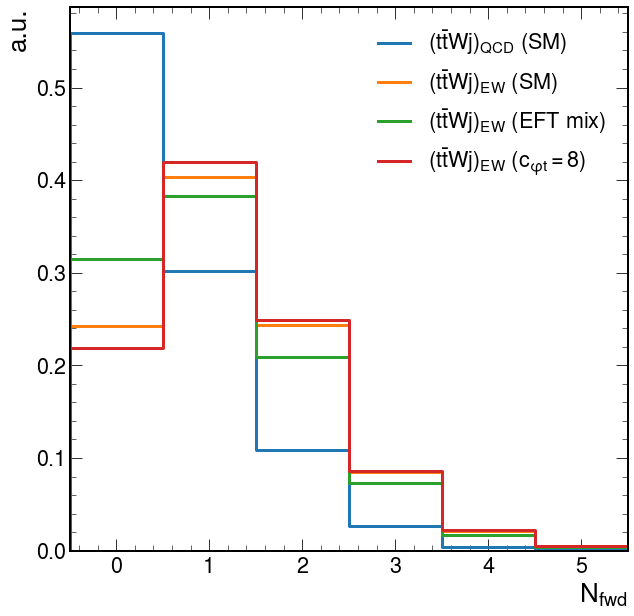

In [51]:
makePlot("N_spec_jet")

<AxesSubplot:xlabel='$m (jj) max \\ (GeV)$', ylabel='a.u.'>

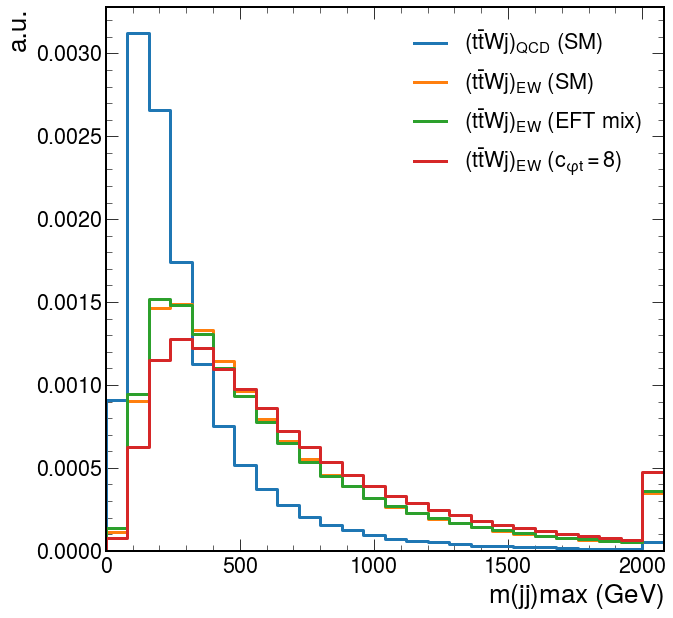

In [83]:
makePlot("m_jj")

<AxesSubplot:xlabel='$m (jj) max \\ (GeV)$', ylabel='a.u.'>

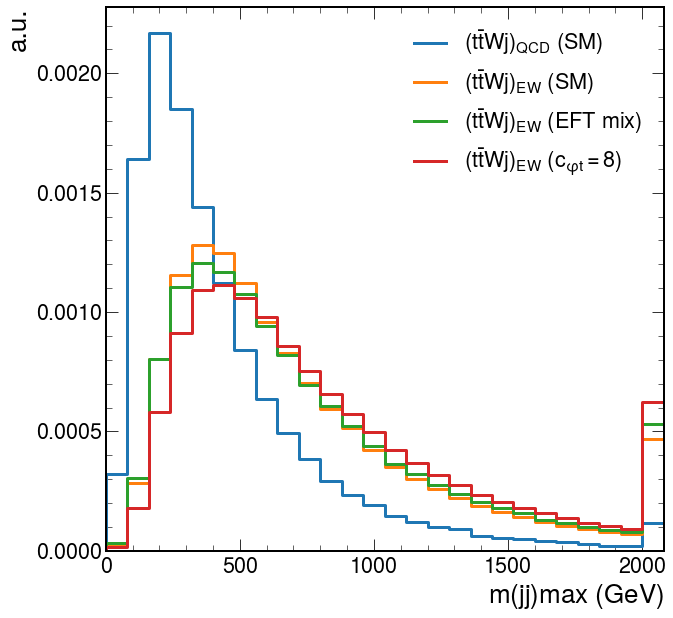

In [88]:
makePlot("m_js")

<AxesSubplot:xlabel='$\\Delta\\eta (jj) $', ylabel='a.u.'>

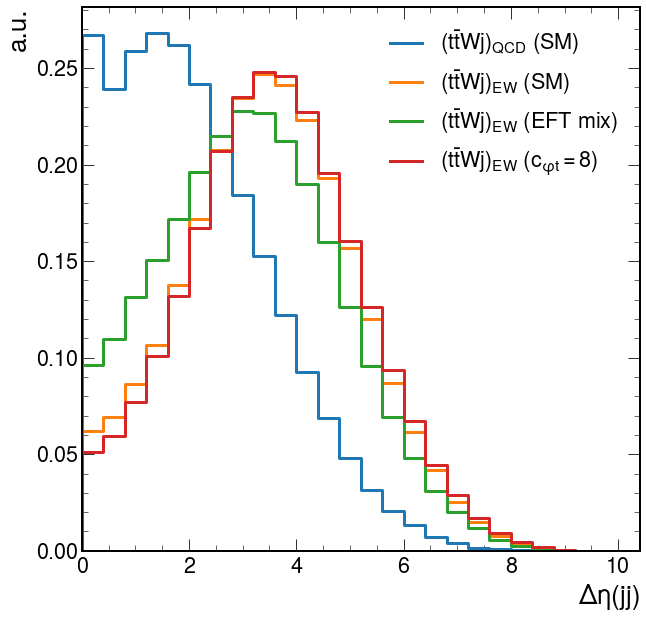

In [96]:
makePlot("deltaEta_jj")

<AxesSubplot:xlabel='$\\Delta\\eta (jj) $', ylabel='a.u.'>

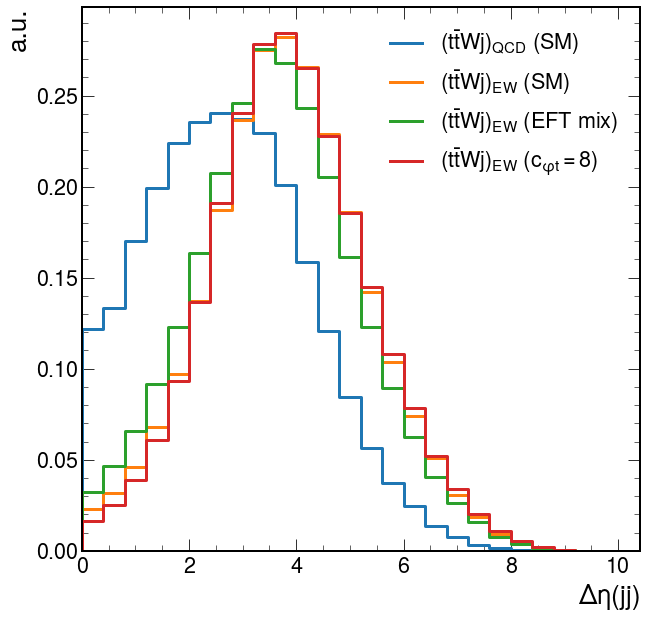

In [97]:
makePlot("deltaEta_any_js")

<AxesSubplot:xlabel='$\\Delta\\eta (jj) $', ylabel='a.u.'>

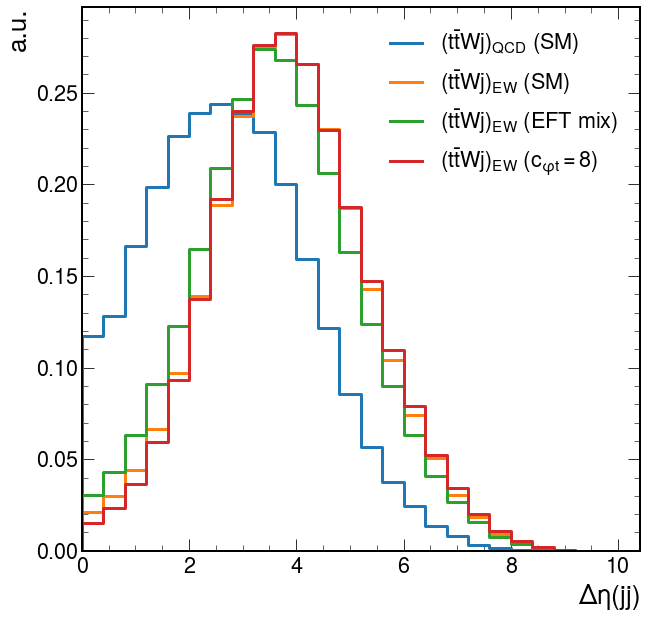

In [81]:
makePlot("deltaEta_js")

<AxesSubplot:xlabel='$\\Delta\\eta (jj) $', ylabel='a.u.'>

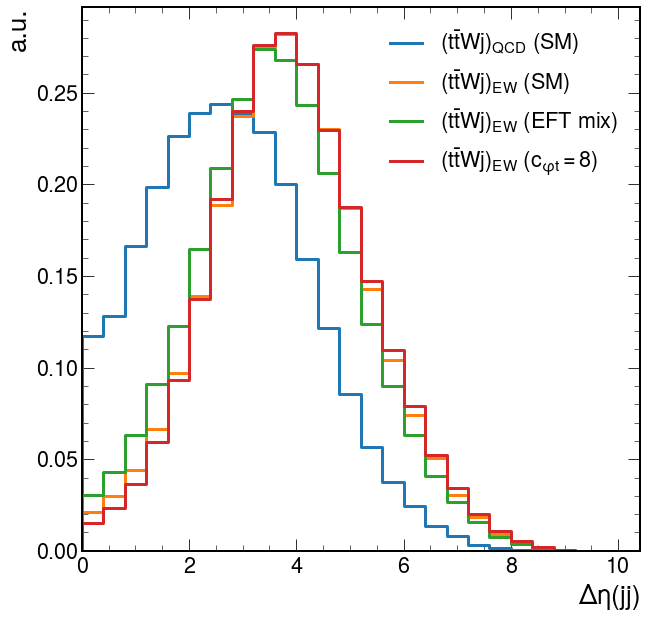

In [69]:
makePlot("deltaEta_bs")

<AxesSubplot:xlabel='$p_T$ (leading W) (GeV)', ylabel='a.u.'>

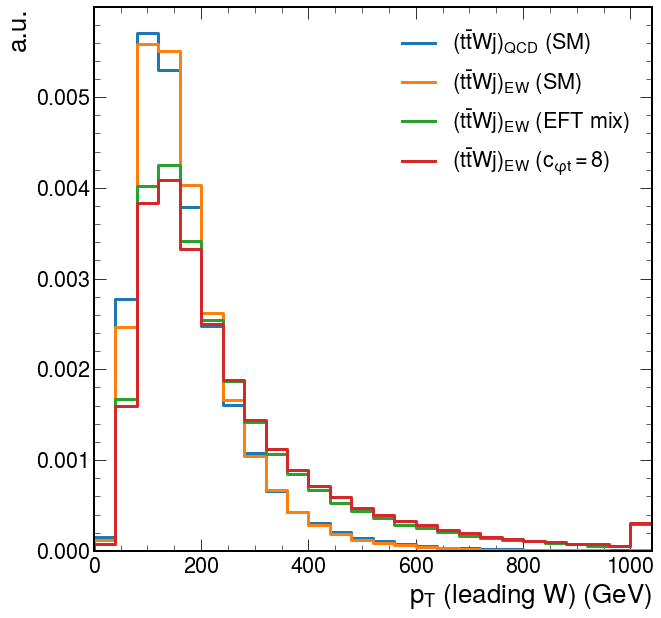

In [44]:
makePlot('leading_W_pt')

<AxesSubplot:xlabel='$p_T$ (trailing W) (GeV)', ylabel='a.u.'>

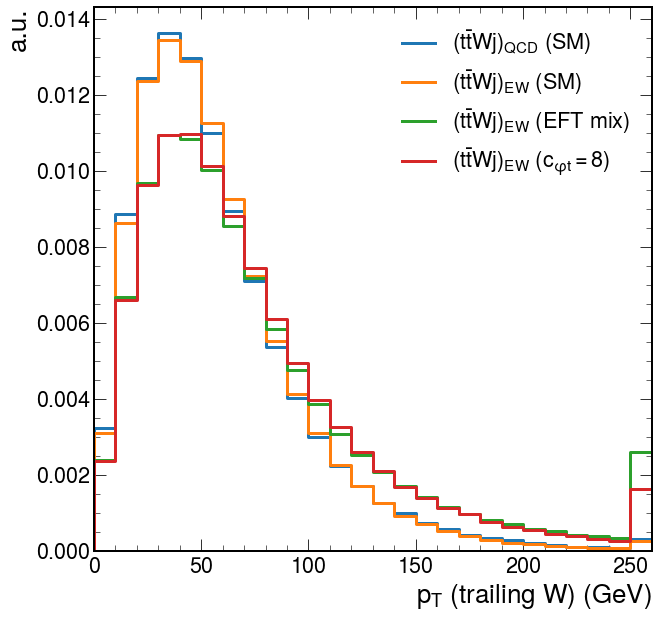

In [45]:
makePlot('trailing_W_pt')

<AxesSubplot:xlabel='$p_T$ (leading top) (GeV)', ylabel='a.u.'>

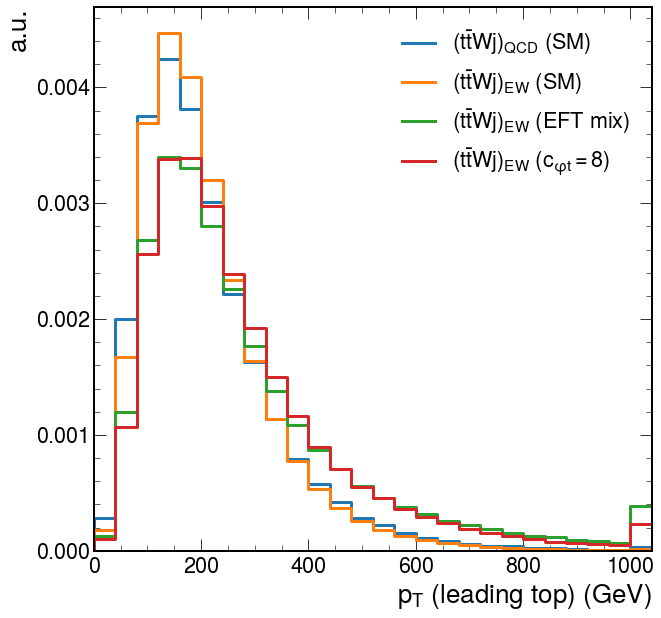

In [46]:
makePlot('leading_top_pt')

<AxesSubplot:xlabel='$p_T$ (trailing top) (GeV)', ylabel='a.u.'>

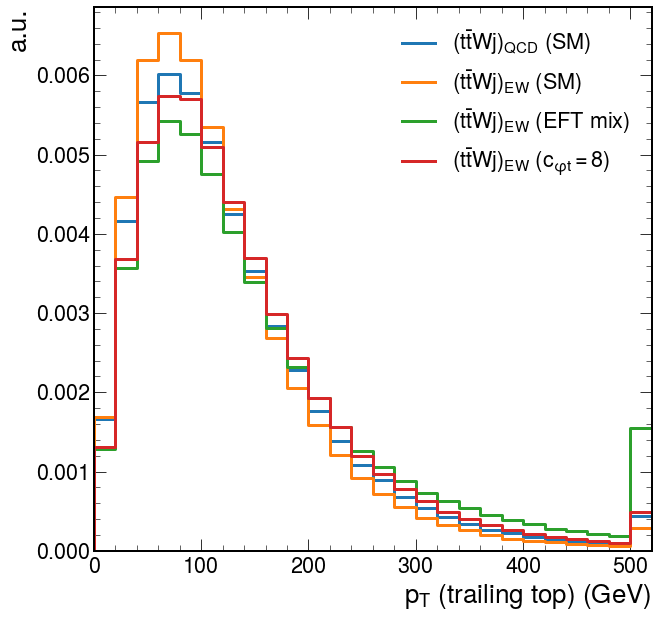

In [47]:
makePlot('trailing_top_pt')

<AxesSubplot:xlabel='$p_T$ (leading b-jet) (GeV)', ylabel='a.u.'>

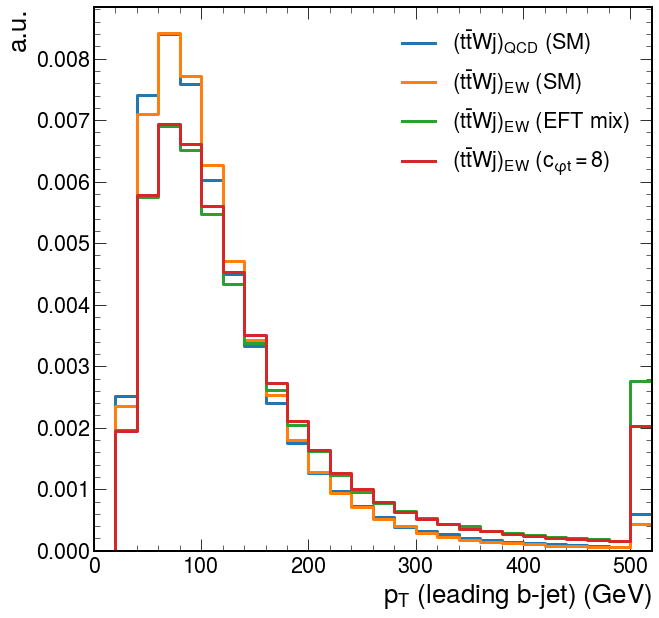

In [48]:
makePlot('leading_bjet_pt')

<AxesSubplot:xlabel='$p_T$ (trailing b-jet) (GeV)', ylabel='a.u.'>

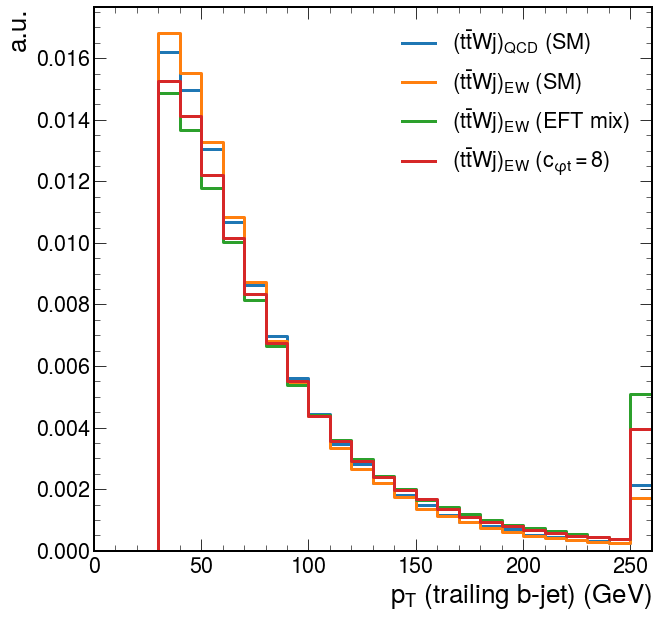

In [49]:
makePlot('trailing_bjet_pt')

<AxesSubplot:xlabel='$p_T$ (spectator) (GeV)', ylabel='a.u.'>

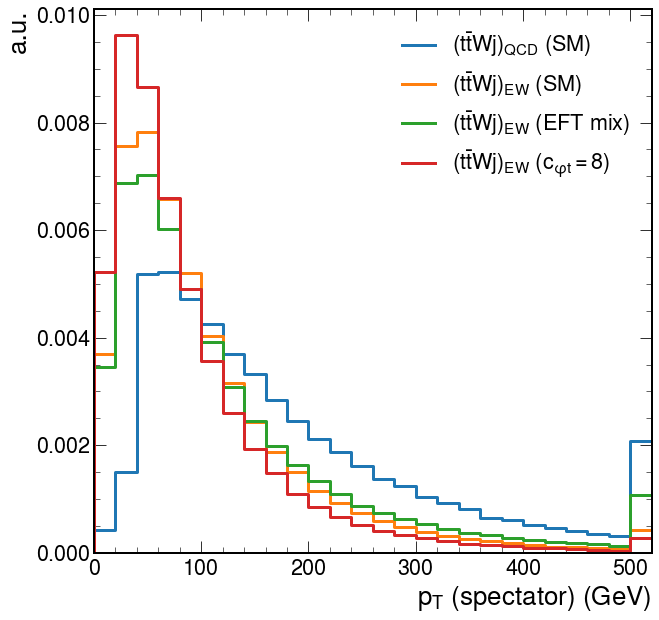

In [50]:
makePlot('spectator_pt')

<AxesSubplot:xlabel='$p_T$ (most forward jet) (GeV)', ylabel='a.u.'>

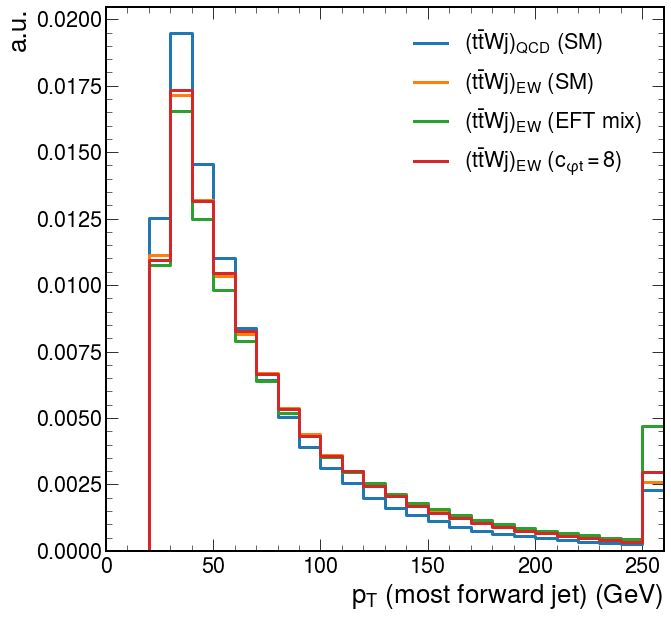

In [51]:
makePlot('fw_pt')

<AxesSubplot:xlabel='$p$ (hardest forward jet) (GeV)', ylabel='a.u.'>

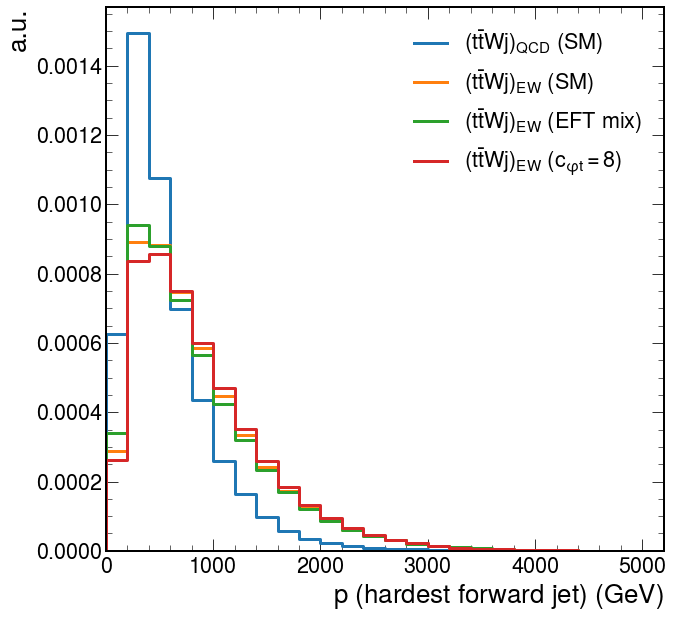

In [52]:
makePlot('leadingForward_p')

<AxesSubplot:xlabel='$m (jj) max \\ (GeV)$', ylabel='a.u.'>

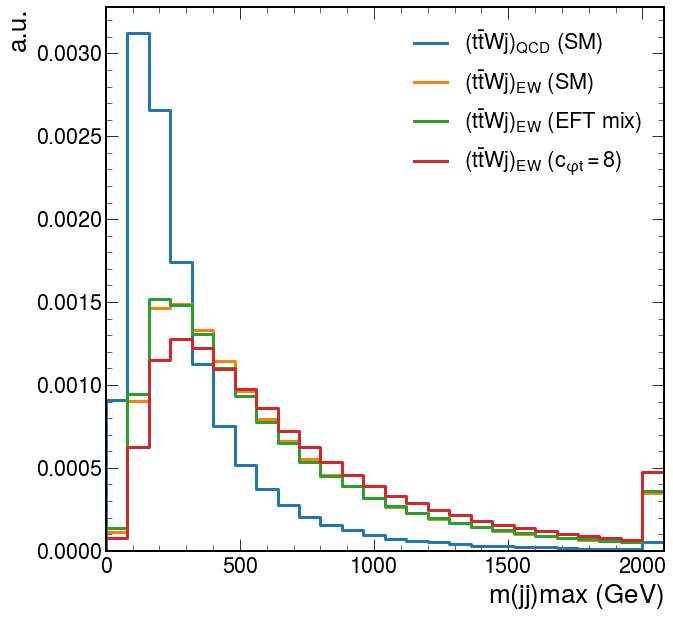

In [53]:
makePlot('m_jj')

<AxesSubplot:xlabel='$\\Delta\\eta (jj) $', ylabel='a.u.'>

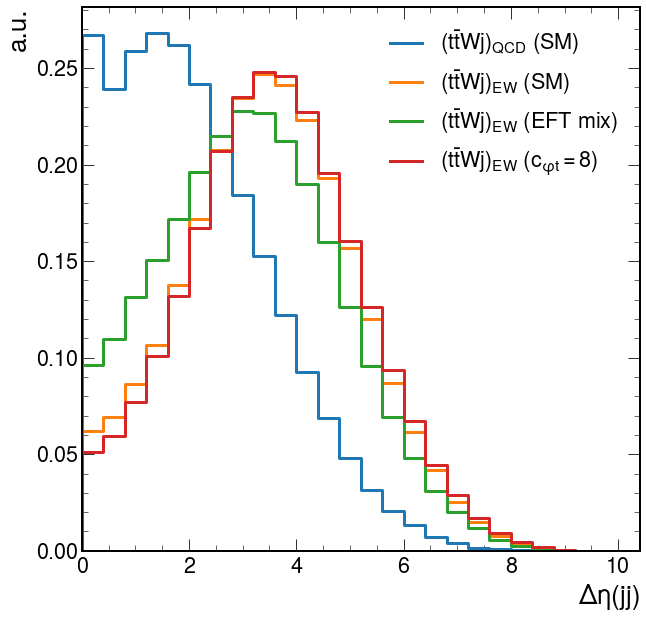

In [49]:
makePlot('deltaEta_jj')

Lessons we can learn from here:
- If the top get's harder, b-jet pt could be an interesting variable
- Highest lepton pt! Could make 3 lepton channel interesting for EFT
- Forward jets / spectator are not really affected, and the effect washes out quickly when one has to look at jets instead of the GenPart
- M(jj) is cool for isolating top-W scattering, but it's unaffected by NP

<AxesSubplot:xlabel='$p_T$ (leading lepton) (GeV)', ylabel='a.u.'>

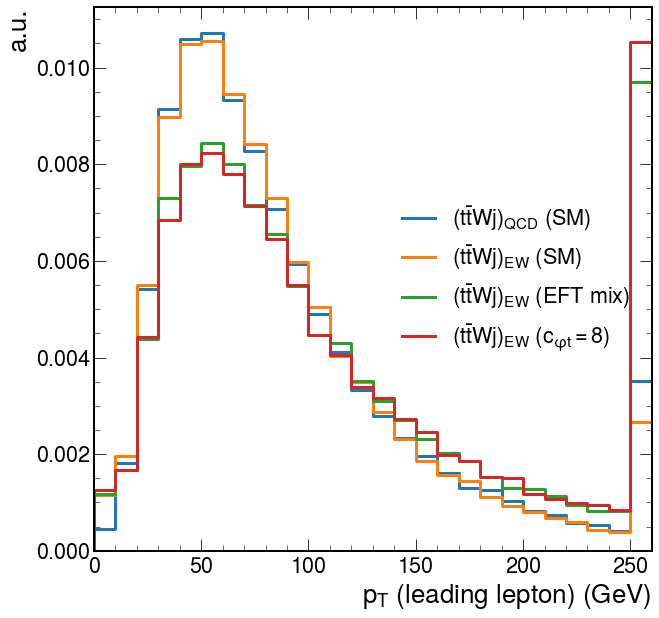

In [55]:
makePlot('leading_lep_pt')

<AxesSubplot:xlabel='$p_T$ (trailing lepton) (GeV)', ylabel='a.u.'>

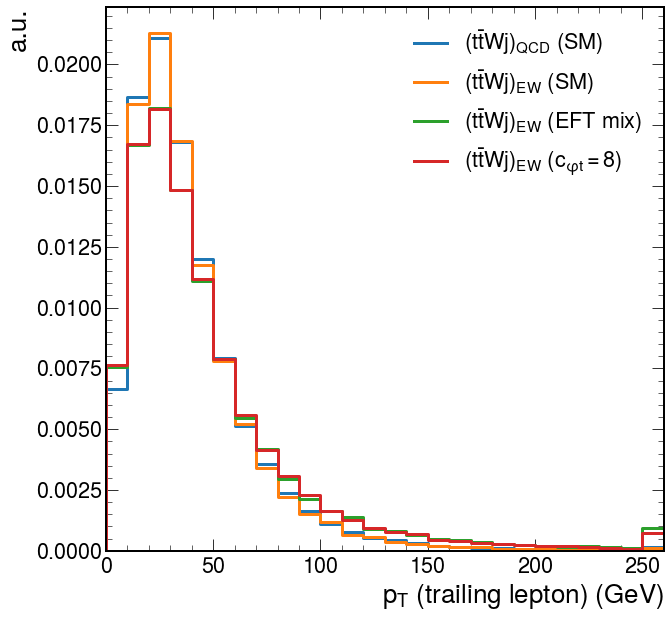

In [56]:
makePlot('trailing_lep_pt')

<AxesSubplot:xlabel='$ H_T $ (GeV)', ylabel='a.u.'>

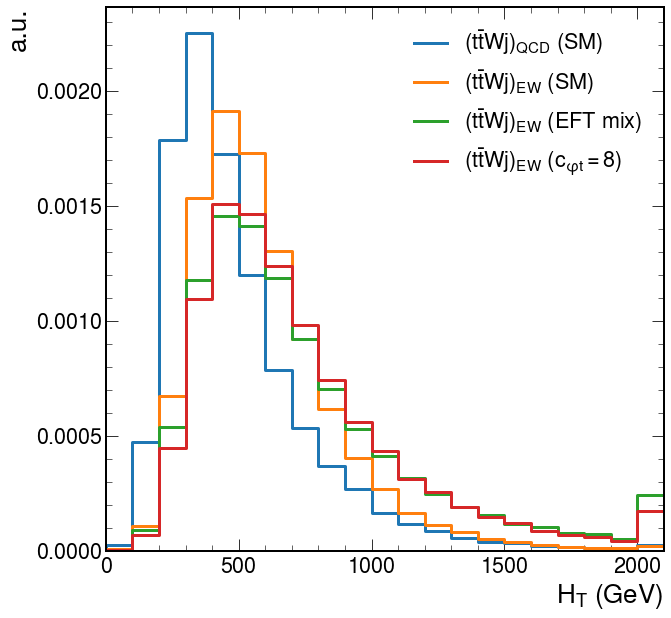

In [61]:
makePlot('ht')

<AxesSubplot:xlabel='$ H_T $ (GeV)', ylabel='a.u.'>

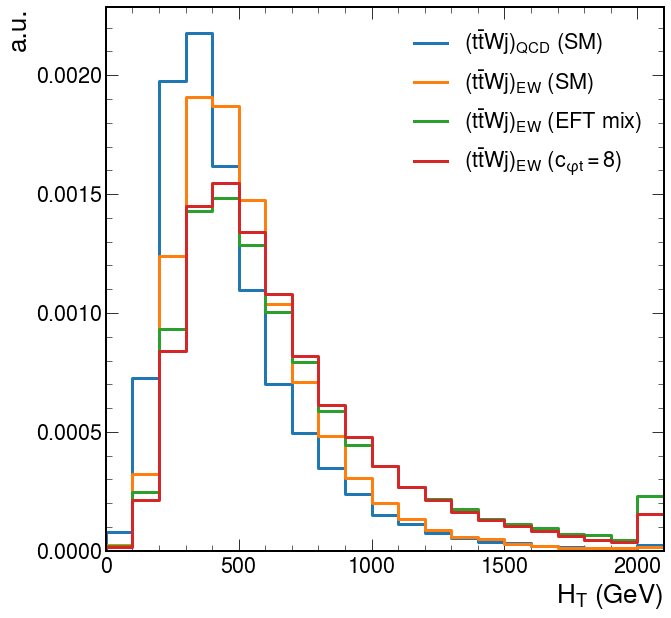

In [60]:
makePlot('ht_central')

In [9]:
from Tools.WH_objects import *

f=uproot4.open('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANOGEN_v1/output_10.root')
tree = f['Events']
df = LazyDataFrame(tree, flatten=False)

GenPart = getGenParts(df)
W_had = getHadW_fromGenPart(GenPart) # or W_had = getHadW(df)